## ML Assignment 02 CNN Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

# Ensure that the correct versions of libraries are installed
print(f'numpy version: {np.__version__}')
print(f'tensorflow version: {tf.__version__}')

2024-05-27 12:34:12.097981: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 12:34:12.140455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


numpy version: 1.26.4
tensorflow version: 2.16.1


### Data Loading and Preprocessing


In [2]:
# Load the dataset using np.genfromtxt
data = np.genfromtxt('traindata.txt', dtype=float, delimiter=',')
labels = np.genfromtxt('trainlabels.txt', dtype=int, delimiter=',')

# Separate features and rotation values
features = data[:, :-1]
rotations = data[:, -1]

#### Noise Identification and Adjustment
- **Identify columns with negative values** (assumed to be noise) and stores their indices in `noise_columns`.
- **Identify columns immediately after the noise columns** and stores their indices in `adjusted_columns`. These values are assumed to be scaled up (x10).
- **Adjust the values** in the `adjusted_columns` by dividing them by 10.
- **Remove the noise columns** from the features to get `features_cleaned`.

In [3]:
# Identify columns with negative values (assumed noise)
noise_columns = [col for col in range(features.shape[1]) if (features[:, col] < 0).any()]

# Identify columns immediately after the noise columns
adjusted_columns = [col + 1 for col in noise_columns if col + 1 < features.shape[1]]

# Divide values in the adjusted columns by 10
features[:, adjusted_columns] = features[:, adjusted_columns] / 10

# Drop the noise columns
features_cleaned = np.delete(features, noise_columns, axis=1)

# Verify the new shape after removing noise columns
print("Cleaned features shape:", features_cleaned.shape)

Cleaned features shape: (5250, 1024)


#### Data Reshaping and Normalization
- **Check the number of columns** in `features_cleaned` to ensure it matches the expected 1024 columns.
- **Reshape each row** of `features_cleaned` into a 32x32 image and adds an extra dimension for the single channel.
- **Rotate the images** based on the rotation values.
- **Normalize the pixel values** to be between 0 and 1.
- **One-hot encodes the labels** to prepare them for classification.

In [4]:
# Check if we have 1024 columns after removing noise and rotation column
if features_cleaned.shape[1] != 1024:
    raise ValueError("Unexpected number of columns after cleaning. Expected 1024 columns.")

# Reshape each row into a 32x32 image
images = features_cleaned.reshape(-1, 32, 32, 1)

# Rotate images based on rotation values
for i in range(len(images)):
    if rotations[i] == 2:
        images[i] = np.rot90(images[i], 2)
    elif rotations[i] == 1:
        images[i] = np.rot90(images[i], 3)
    elif rotations[i] == 3:
        images[i] = np.rot90(images[i], 1)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# One-hot encode labels
labels = tf.keras.utils.to_categorical(labels, num_classes=21)

#### Data Splitting
- Training data: first 4200 samples.
- Validation data: samples from 4200 to 4725.
- Test data: samples from 4725 onwards.

or **Shuffle the Data then Split**:
- Create an array of indices using `np.arange(images.shape[0])`.
- Shuffle the indices using `np.random.shuffle(indices)`.
- Apply the shuffled indices to both `images` and `labels`.
- Calculate `train_size`, `val_size`, and `test_size` based on proportions (80% for training, 10% for validation, and 10% for testing).
- Split the shuffled data into training, validation, and test sets accordingly.

comment out either option and use one.

In [5]:
# Split data into training, validation, and test sets
train_images, train_labels = images[:4200], labels[:4200]
val_images, val_labels = images[4200:4725], labels[4200:4725]
test_images, test_labels = images[4725:], labels[4725:]

# Shuffle the data
# indices = np.arange(images.shape[0])
# np.random.shuffle(indices)
# images = images[indices]
# labels = labels[indices]

# Split data into training, validation, and test sets
# train_size = int(0.8 * images.shape[0])
# val_size = int(0.1 * images.shape[0])
# test_size = images.shape[0] - train_size - val_size

# train_images, train_labels = images[:train_size], labels[:train_size]
# val_images, val_labels = images[train_size:train_size + val_size], labels[train_size:train_size + val_size]
# test_images, test_labels = images[train_size + val_size:], labels[train_size + val_size:]

### Model Construction
- **Build the CNN model** using the Sequential API:
- **Conv2D layers**: for convolution operations.
- **MaxPooling2D layers**: for downsampling.
- **Flatten layer**: to flatten the 2D outputs to 1D.
- **Dense layers**: fully connected layers.
- **Dropout layer**: to prevent overfitting.
- **Output layer**: with 21 units (one for each class) and softmax activation for classification.

In [6]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=regularizers.l2(0.0001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.07))
model.add(Dense(21, activation='softmax'))


/home/sean-mz/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compilation
**Compile the Model**:
- Optimizer: Adam.
- Loss function: categorical crossentropy.
- Metric: accuracy.

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Model Training
**Train the model** using the training data and validates it on the validation data.
Parameters:
- Epochs: 10.
- Batch size: 32.

In [8]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1313 - loss: 2.8528 - val_accuracy: 0.4419 - val_loss: 1.9377
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5058 - loss: 1.7762 - val_accuracy: 0.5752 - val_loss: 1.5223
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6141 - loss: 1.3969 - val_accuracy: 0.6229 - val_loss: 1.3428
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6757 - loss: 1.1729 - val_accuracy: 0.6362 - val_loss: 1.3371
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6871 - loss: 1.0856 - val_accuracy: 0.6533 - val_loss: 1.2994
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7153 - loss: 0.9731 - val_accuracy: 0.6686 - val_loss: 1.2635
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7417 - loss: 0.9064 - val_accuracy: 0.6724 - val_loss: 1.2392
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7689 - loss: 0.8077 - val_accu

### Model Evaluation
Evaluate the model on the test set and prints the test accuracy.

In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy:', test_acc)

17/17 - 0s - 5ms/step - accuracy: 0.7238 - loss: 1.0433
Test accuracy: 0.723809540271759


#### Plot Training and Validation Accuracy
Plot the training and validation accuracy over the epochs to visualize the model's performance

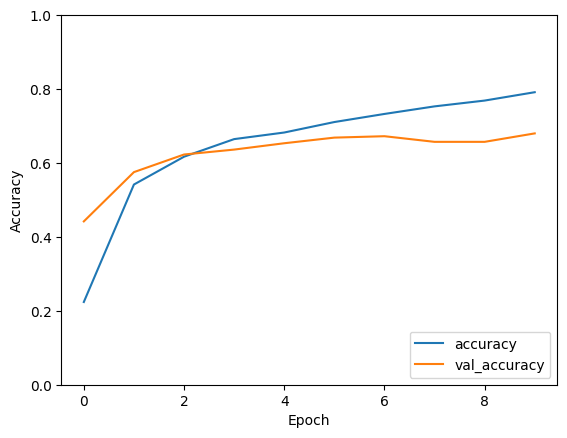

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#### Predictions and Output
- **Make predictions** on the test set.
- **Extract the predicted and true labels.**
- **Write the true and predicted labels** to a text file `test_predictions.txt` for comparison.

In [11]:
# Predict labels for the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Write the true and predicted labels to a text file
with open('test_predictions.txt', 'w') as f:
    f.write('TrueLabel,PredictedLabel\n')
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        f.write(f'{true_label},{predicted_label}\n')


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
